In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html

In [2]:
G = scipy.signal.lti([1], [15, 8, 1])

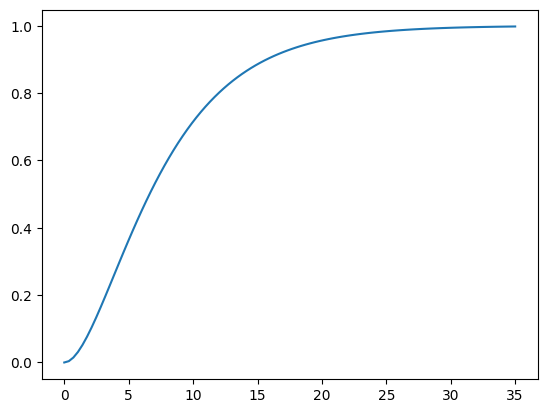

In [3]:
plt.plot(*G.step())

In [4]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

In [5]:
tcontinuous = numpy.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

In [7]:
tau_c = 1
r = 1 - numpy.exp(-tpredict/tau_c)

In [8]:
u = numpy.ones(M)

In [9]:
x0 = numpy.zeros(G.to_ss().A.shape[0])

In [10]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

In [11]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

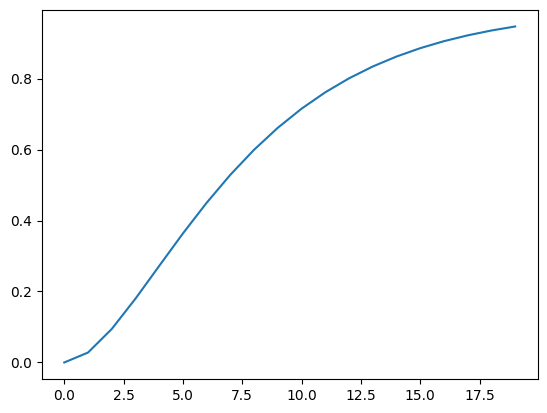

In [12]:
plt.plot(tpredict, prediction(extend(u)))

In [13]:
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)

In [18]:
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = numpy.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(numpy.abs(numpy.diff(u)))
    strongfinish = numpy.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0*constraintpenalty + 0.1*movepenalty + 0*strongfinish

In [19]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

0.9051481750022587

In [20]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

In [21]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

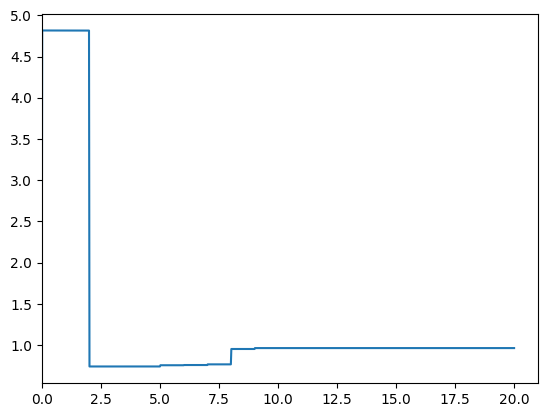

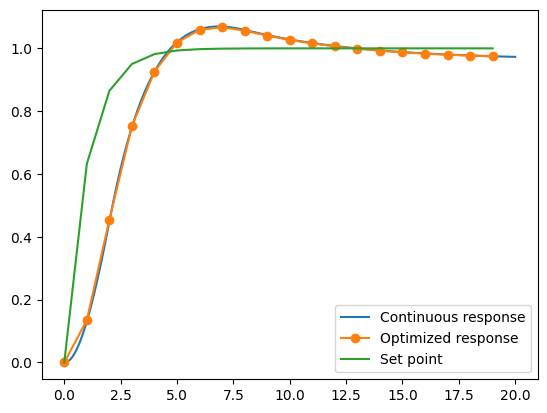

In [22]:

plotoutput(ucont, uopt)